In [111]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
from statsmodels.graphics.api import qqplot
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

#### Bitcon Daily Data from Sept 17 2017 to July 27 2022 (Almost 5 years) 

In [2]:
df = pd.read_csv('../Data/BTC-USD(3)', index_col=[0],parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-28,2679.729980,2897.449951,2679.729980,2809.010010,2809.010010,1.380100e+09
2017-07-29,2807.020020,2808.760010,2692.800049,2726.449951,2726.449951,8.037460e+08
2017-07-30,2724.389893,2758.530029,2644.850098,2757.179932,2757.179932,7.059430e+08
2017-07-31,2763.239990,2889.620117,2720.610107,2875.340088,2875.340088,8.605750e+08
2017-08-01,2871.300049,2921.350098,2685.610107,2718.260010,2718.260010,1.324670e+09


### Train and Test Split

In [3]:
df_new=df.reset_index()

In [4]:
df_total = df['Close']

In [5]:
df_train=df_new[df_new['Date']<"2021-07-28"]
df_train.set_index('Date', inplace=True)
data_train = df_train[['Close']]
data_train

,Close
Date,
2017-07-28,2809.010010
2017-07-29,2726.449951
2017-07-30,2757.179932
2017-07-31,2875.340088
2017-08-01,2718.260010
...,...
2021-07-23,33581.550780
2021-07-24,34292.445310
2021-07-25,35350.187500


In [6]:
df_test=df_new[df_new['Date']>="2021-07-28"]
df_test.set_index('Date', inplace=True)
data_test = df_test[['Close']]
data_test

,Close
Date,
2021-07-28,39995.90625
2021-07-29,40008.42188
2021-07-30,42235.54688
2021-07-31,41626.19531
2021-08-01,39974.89453
...,...
2022-07-23,22465.47852
2022-07-24,22609.16406
2022-07-25,21361.70117


In [7]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data_train, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput 

Test Statistic                   -0.562305
p-value                           0.879274
#lags Used                       24.000000
Number of Observations Used    1436.000000
dtype: float64

<AxesSubplot:xlabel='Date'>

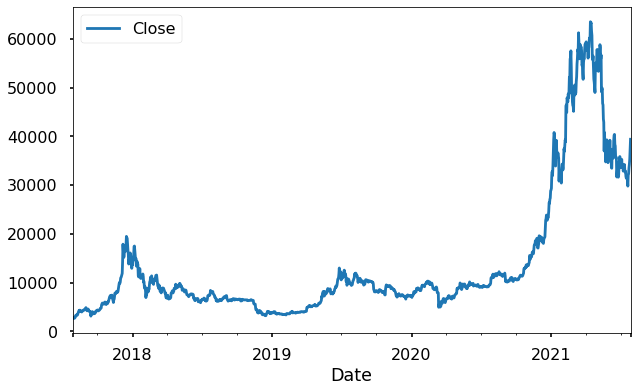

In [8]:
data_train.plot()

Dickey–Fuller test: p=0.879274


<Figure size 7200x2880 with 0 Axes>

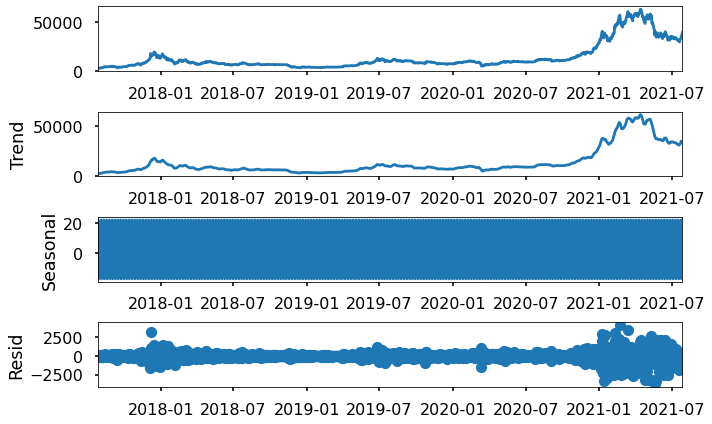

In [9]:
plt.figure(figsize=[100,40])
sm.tsa.seasonal_decompose(data_train).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_train)[1])
plt.show()

## You can not see a proper visible trend in the data and there is absolutely NO seasonality

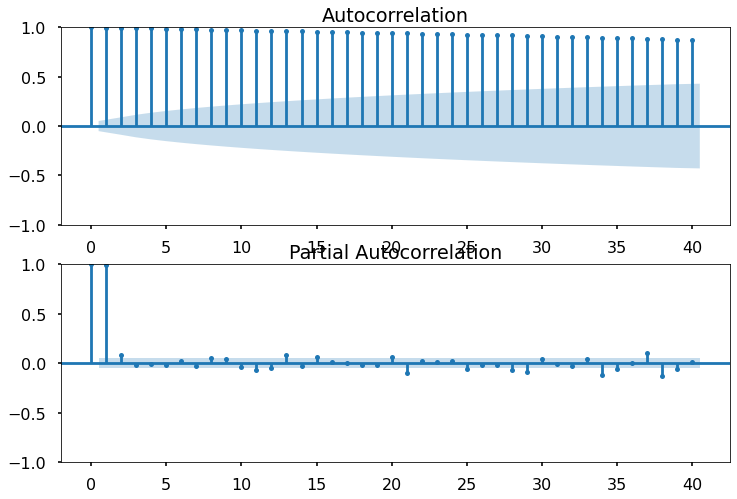

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_train.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_train, lags=40, ax=ax2)

In [11]:
data_train['Boxcox'], lmbda = stats.boxcox(data_train.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_train.Boxcox)[1])

Dickey–Fuller test: p=0.444260


In [12]:
result_kpss_ct=kpss(data_train['Boxcox'],regression="ct")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.607334
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [13]:
df_boxcox = data_train[['Boxcox']]

## Not Stationary with Boxcox, however the p-value has been decrease a lot from 0.879 to 0.444 in Dickey Fuller Test 

## Log Transformation

In [14]:
df_log = np.log(data_train['Close'])

In [15]:
dftest = adfuller(df_log, autolag='AIC')
dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput1

Test Statistic                   -0.977020
p-value                           0.761553
#lags Used                       10.000000
Number of Observations Used    1450.000000
dtype: float64

## NOT Stationary p-value is little decrease with log from actual dataset but it is very high although 0.761

## Cube Root Transformation

In [16]:
df_cbrt = np.cbrt(data_train['Close'])
df_cbrt

Date
2017-07-28    14.109699
2017-07-29    13.970089
2017-07-30    14.022379
2017-07-31    14.219896
2017-08-01    13.956087
                ...    
2021-07-23    32.262666
2021-07-24    32.488736
2021-07-25    32.819395
2021-07-26    33.423240
2021-07-27    34.029657
Name: Close, Length: 1461, dtype: float64

In [17]:
dftest = adfuller(df_cbrt, autolag='AIC')
dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput1

Test Statistic                   -0.529012
p-value                           0.886230
#lags Used                       23.000000
Number of Observations Used    1437.000000
dtype: float64

## Cube Root is Even bad 0.88

## Standardization Transformation

In [18]:
data_train_np = data_train['Close'].to_numpy().reshape(-1, 1)

In [19]:
# fit transform
transformer = StandardScaler()
transformer.fit(data_train_np)
# difference transform
df_std = transformer.transform(data_train_np)
print(df_std)

[[-0.79633575]
 [-0.8024266 ]
 [-0.8001595 ]
 ...
 [ 1.60438158]
 [ 1.75099766]
 [ 1.90366759]]


In [20]:
dftest = adfuller(df_std, autolag='AIC')
dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput1

Test Statistic                   -0.562305
p-value                           0.879274
#lags Used                       24.000000
Number of Observations Used    1436.000000
dtype: float64

## Not at all Stationary

## Normalization Transformation

In [21]:
transformer = MinMaxScaler()
transformer.fit(data_train_np)
df_norm = transformer.transform(data_train_np)
print(df_norm)

[[1.61762756e-03]
 [2.59570744e-04]
 [7.65058031e-04]
 ...
 [5.36897865e-01]
 [5.69588382e-01]
 [6.03628707e-01]]


In [22]:
dftest = adfuller(df_norm, autolag='AIC')
dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput1

Test Statistic                   -0.562305
p-value                           0.879274
#lags Used                       24.000000
Number of Observations Used    1436.000000
dtype: float64

## Not at all Stationary

## Difffernce Transformation

In [23]:
df_diffonly = data_train['Close'].diff().dropna()

In [24]:
dftest = adfuller(df_diffonly, autolag='AIC')
dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput1

Test Statistic                -7.145689e+00
p-value                        3.237350e-10
#lags Used                     2.400000e+01
Number of Observations Used    1.435000e+03
dtype: float64

## IT is Very Very Near to Stationary

<AxesSubplot:xlabel='Date'>

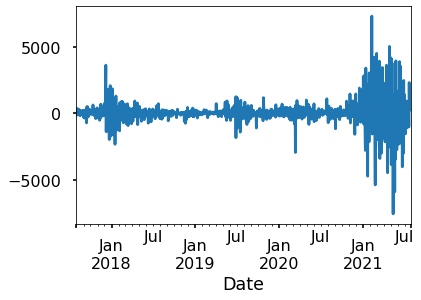

In [25]:
df_diffonly.plot()

## Square Root Transformation and difference Transform

In [26]:
df_sqrt = np.sqrt(data_train['Close'])
print(df_sqrt)
df_diff = df_sqrt.diff().dropna()

Date
2017-07-28     53.000094
2017-07-29     52.215419
2017-07-30     52.508856
2017-07-31     53.622198
2017-08-01     52.136935
                 ...    
2021-07-23    183.252697
2021-07-24    185.182195
2021-07-25    188.016455
2021-07-26    193.229230
2021-07-27    198.511817
Name: Close, Length: 1461, dtype: float64


In [27]:
df_diff

Date
2017-07-29   -0.784676
2017-07-30    0.293437
2017-07-31    1.113342
2017-08-01   -1.485263
2017-08-02   -0.072841
                ...   
2021-07-23    3.494232
2021-07-24    1.929498
2021-07-25    2.834260
2021-07-26    5.212774
2021-07-27    5.282587
Name: Close, Length: 1460, dtype: float64

In [28]:
dftest = adfuller(df_sqrt, autolag='AIC')
dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput1

Test Statistic                   -0.506426
p-value                           0.890756
#lags Used                       24.000000
Number of Observations Used    1436.000000
dtype: float64

## NOT Stationary- Sqrt is even bad

In [29]:
dftest = adfuller(df_diff, autolag='AIC')
dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
dfoutput1

Test Statistic                -7.454900e+00
p-value                        5.545411e-11
#lags Used                     2.300000e+01
Number of Observations Used    1.436000e+03
dtype: float64

In [30]:
result_kpss_ct=kpss(df_diff,regression="ct")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.088089
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


## With difference transformation and after Square Root is Very Very Near to Stationary 

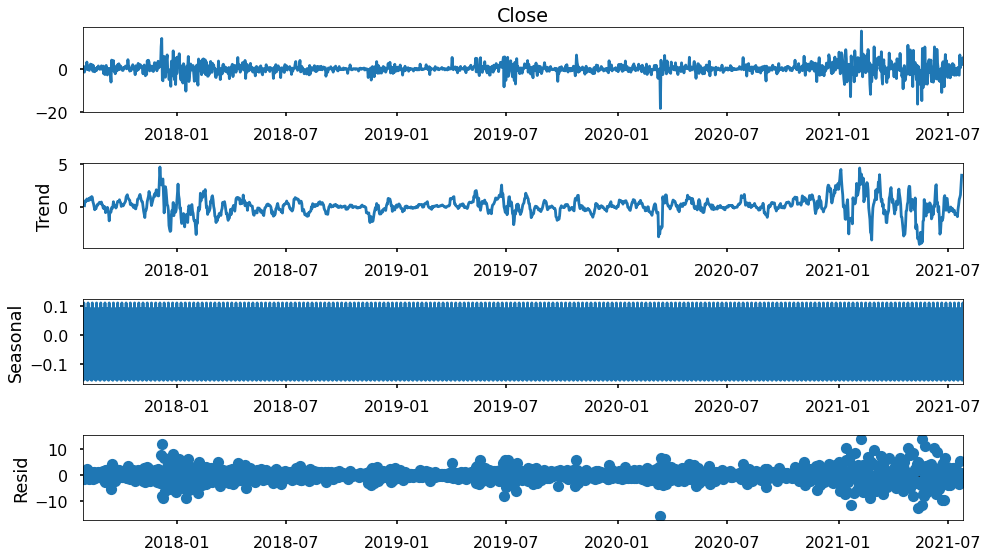

In [31]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)
result = seasonal_decompose(df_diff,model='additive')
fig = result.plot()

### Not Such Trend and Not at all Seasonality

# Applying Model
# ARIMA

## Choosing Hyperparameters for my models p,q and d

## There 3 methods 
### 1. ACF and PACF Plots
### 2. For Loop (passing all the possible combination of p,q, and d)
### 3. AUTO_ARIMA Function

<AxesSubplot:xlabel='Date'>

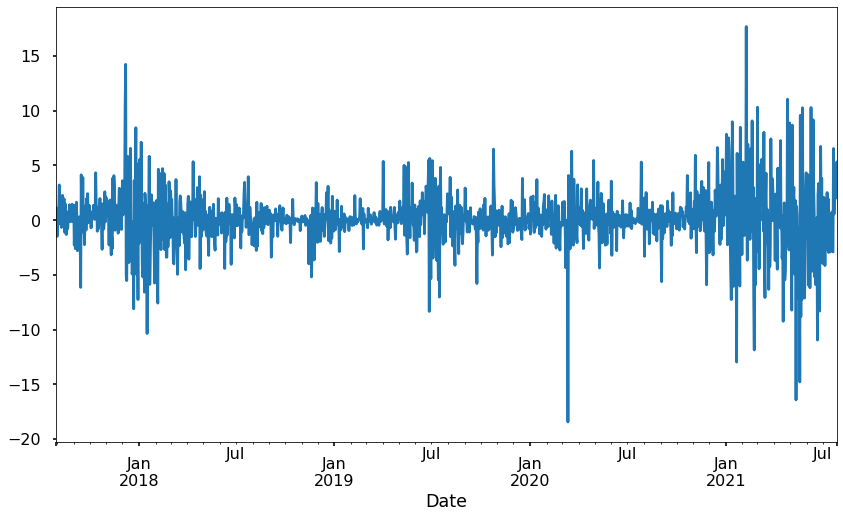

In [32]:
df_diff.plot()

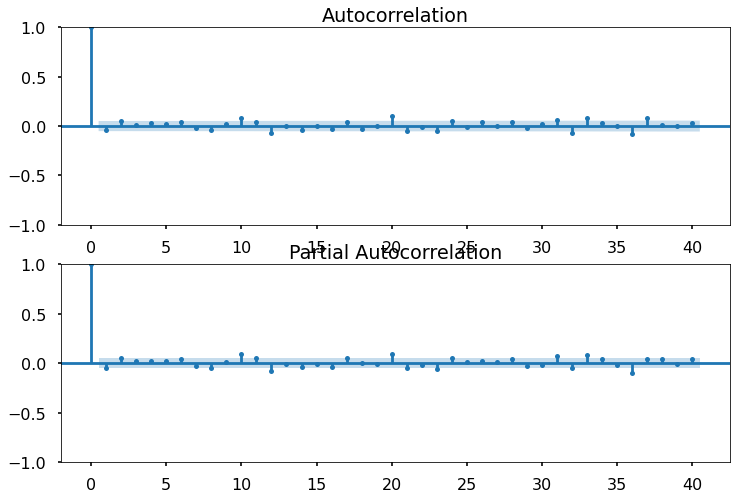

In [33]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff.values.squeeze(), lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff, lags=40, ax=ax2)

In [34]:
len(data_train), len(data_test)

(1461, 365)

In [35]:
p = range(0,8)
q = range(0,8)
d = range(0,2)

In [36]:
pdq_combination = list(itertools.product(p,d,q))

In [37]:
len(pdq_combination)

128

In [38]:
test_sqs = data_test['Close'].to_list()
def reverse_1(diffs):
    diffss = diffs.to_list()
    test_sqrt = [test_sq **(1/2) for test_sq in test_sqs]
    reverse_diffs = [x + y for (x, y) in zip(test_sqrt, diffss)]
    total_reverses = [x**2 for x in reverse_diffs]
    return(total_reverses)

In [39]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
rmse = []
order1 = []
for pdq in pdq_combination:
    try:
        model = ARIMA(df_diff, order=pdq).fit()
        pred = model.predict(start=1460,end=1824)
        pred_rev = reverse_1(pred)
        error = np.sqrt(mean_squared_error(data_test,pred_rev))
        order1.append(pdq)
        rmse.append(error)
    except:
        print('error aaya')
        break

In [40]:
results = pd.DataFrame(index = order1, data = rmse, columns = ['RMSE'])

In [41]:
results

,RMSE
"(0, 0, 0)",40.881854
"(0, 0, 1)",40.860533
"(0, 0, 2)",41.671051
"(0, 0, 3)",42.099014
"(0, 0, 4)",43.399294
...,...
"(7, 1, 3)",59.307155
"(7, 1, 4)",100.584228
"(7, 1, 5)",83.021557
"(7, 1, 6)",79.748803


In [42]:
results.sort_values('RMSE')

,RMSE
"(1, 1, 1)",33.400728
"(0, 1, 2)",37.085805
"(0, 0, 1)",40.860533
"(0, 0, 0)",40.881854
"(1, 0, 0)",40.902020
...,...
"(4, 1, 0)",1739.899491
"(3, 1, 0)",1838.490611
"(2, 1, 0)",2017.222129
"(1, 1, 0)",2183.680738


## Got our Best Hyperparameters that is (1,1,1) which as the minimum rmse or mse value that is 33.400728

## Fit Model with Best Hyperparameters (1,1,1)

In [43]:
model_best = ARIMA(df_diff, order=(1,1,1)).fit()

In [44]:
pred_best = model.predict(start=1460,end=1824)

In [45]:
pred_best_rev = reverse_1(pred_best)

In [46]:
data_test.rename(columns = {'Close':'test'}, inplace = True)
data_test['pred'] = pred_best_rev

In [47]:
data_test

,test,pred
Date,,
2021-07-28,39995.90625,40015.122954
2021-07-29,40008.42188,39446.514103
2021-07-30,42235.54688,42791.305223
2021-07-31,41626.19531,41729.440083
2021-08-01,39974.89453,40076.473703
...,...,...
2022-07-23,22465.47852,22514.518922
2022-07-24,22609.16406,22665.399476
2022-07-25,21361.70117,21411.336733


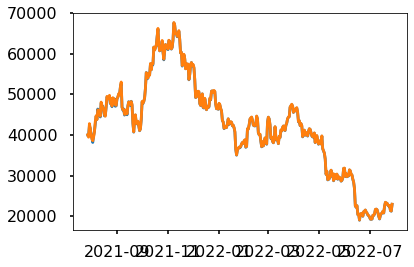

In [48]:
plt.plot(data_test)

In [49]:
error = np.sqrt(mean_squared_error(data_test['test'],data_test['pred']))

In [50]:
error

117.52177100789598

In [51]:
mean = df_total.mean()
mean

19289.016067654964

In [52]:
percentage_rmse_data_mean = (error/mean)*100
percentage_rmse_data_mean 

0.6092678371758105

## Predict the Unseen future 

In [53]:
df_total

Date
2017-07-28     2809.010010
2017-07-29     2726.449951
2017-07-30     2757.179932
2017-07-31     2875.340088
2017-08-01     2718.260010
                  ...     
2022-07-23    22465.478520
2022-07-24    22609.164060
2022-07-25    21361.701170
2022-07-26    21239.753910
2022-07-27    22930.548830
Name: Close, Length: 1826, dtype: float64

In [54]:
df_total_sqrt = np.sqrt(df_total)
df_total_diff = df_total_sqrt.diff().dropna()

In [55]:
df_total_diff

Date
2017-07-29   -0.784676
2017-07-30    0.293437
2017-07-31    1.113342
2017-08-01   -1.485263
2017-08-02   -0.072841
                ...   
2022-07-23   -0.830007
2022-07-24    0.478556
2022-07-25   -4.207013
2022-07-26   -0.417778
2022-07-27    5.689713
Name: Close, Length: 1825, dtype: float64

In [56]:
future_model = ARIMA(df_total_diff,order = (1,1,1)).fit()

In [57]:
pred_future = future_model.predict(start = 1825, end= 2189)

In [58]:
pred_future

2022-07-28   -0.326487
2022-07-29   -0.175645
2022-07-30   -0.179427
2022-07-31   -0.179332
2022-08-01   -0.179334
                ...   
2023-07-23   -0.179334
2023-07-24   -0.179334
2023-07-25   -0.179334
2023-07-26   -0.179334
2023-07-27   -0.179334
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [59]:
pred_future_rev = reverse_1(pred_future)

In [60]:
final_data = pd.DataFrame(pred_future)

In [61]:
final_data['pred_rev'] = pred_future_rev

In [62]:
final_data

,predicted_mean,pred_rev
2022-07-28,-0.326487,39865.424707
2022-07-29,-0.175645,39938.187382
2022-07-30,-0.179427,42161.829994
2022-07-31,-0.179332,41553.051022
2022-08-01,-0.179334,39903.215425
...,...,...
2023-07-23,-0.179334,22411.751651
2023-07-24,-0.179334,22555.265548
2023-07-25,-0.179334,21309.311583
2023-07-26,-0.179334,21187.514166


<AxesSubplot:xlabel='Date'>

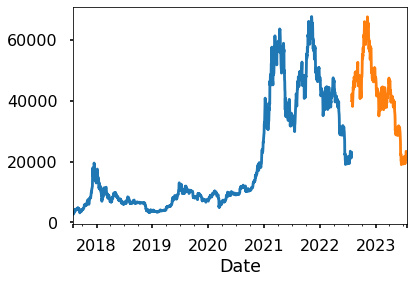

In [63]:
df_total.plot()
final_data['pred_rev'].plot()

## Auto_Arima

In [64]:
import pmdarima as pm

In [65]:
model_auto = pm.auto_arima(df_total, trace = True, suppress_warnings = True, start_p=0, start_q=0, start_d=0, max_p=8, max_q=8, max_d=2) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30434.475, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30435.221, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30435.236, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30432.692, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30437.218, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds


In [66]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1826
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -15215.346
Date:                Tue, 09 Aug 2022   AIC                          30432.692
Time:                        10:17:56   BIC                          30438.201
Sample:                             0   HQIC                         30434.724
                               - 1826                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.021e+06    1.4e+04     72.842      0.000    9.93e+05    1.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):              7057.37
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):              14.86   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## The Hyperparameter suggested by the auto_arima model is (0,1,0)

In [67]:
model_autohy = ARIMA(data_train['Close'], order=(0,1,0)).fit()

In [68]:
pred_autohy = model_autohy.predict(start=1460,end=1824)

In [69]:
pred_autohy

2021-07-27    37337.53516
2021-07-28    39406.94141
2021-07-29    39406.94141
2021-07-30    39406.94141
2021-07-31    39406.94141
                 ...     
2022-07-22    39406.94141
2022-07-23    39406.94141
2022-07-24    39406.94141
2022-07-25    39406.94141
2022-07-26    39406.94141
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

<AxesSubplot:xlabel='Date'>

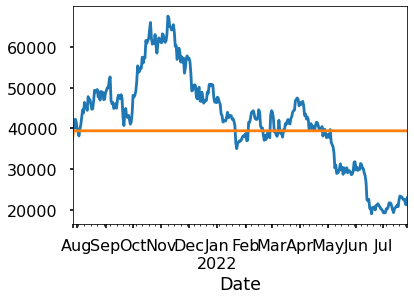

In [70]:
data_test['test'].plot()
pred_autohy.plot()

In [71]:
error = np.sqrt(mean_squared_error(data_test['test'],pred_autohy))

In [72]:
error

11896.351212140102

## Random forest 

In [73]:
df_total

Date
2017-07-28     2809.010010
2017-07-29     2726.449951
2017-07-30     2757.179932
2017-07-31     2875.340088
2017-08-01     2718.260010
                  ...     
2022-07-23    22465.478520
2022-07-24    22609.164060
2022-07-25    21361.701170
2022-07-26    21239.753910
2022-07-27    22930.548830
Name: Close, Length: 1826, dtype: float64

In [74]:
df_yesterday = df_total.shift(+1)
df_aday_before_yesterday = df_total.shift(+2)

In [75]:
temp = pd.concat([df_aday_before_yesterday,df_yesterday,df_total], axis=1)
temp.columns = ['aday_before_yesterday', 'yesterday', 'Today']
temp

,aday_before_yesterday,yesterday,Today
Date,,,
2017-07-28,NaN,NaN,2809.010010
2017-07-29,NaN,2809.010010,2726.449951
2017-07-30,2809.010010,2726.449951,2757.179932
2017-07-31,2726.449951,2757.179932,2875.340088
2017-08-01,2757.179932,2875.340088,2718.260010
...,...,...,...
2022-07-23,23164.628910,22714.978520,22465.478520
2022-07-24,22714.978520,22465.478520,22609.164060
2022-07-25,22465.478520,22609.164060,21361.701170


In [76]:
temp = temp.dropna()
temp

,aday_before_yesterday,yesterday,Today
Date,,,
2017-07-30,2809.010010,2726.449951,2757.179932
2017-07-31,2726.449951,2757.179932,2875.340088
2017-08-01,2757.179932,2875.340088,2718.260010
2017-08-02,2875.340088,2718.260010,2710.669922
2017-08-03,2718.260010,2710.669922,2804.729980
...,...,...,...
2022-07-23,23164.628910,22714.978520,22465.478520
2022-07-24,22714.978520,22465.478520,22609.164060
2022-07-25,22465.478520,22609.164060,21361.701170


In [77]:
X=temp[['aday_before_yesterday','yesterday']]
y=temp[['Today']]
type(y)

pandas.core.frame.DataFrame

In [78]:
X_train=X.reset_index()
X_train=X_train[X_train['Date']<"2021-07-28"]
X_train.set_index('Date', inplace=True)
X_train

,aday_before_yesterday,yesterday
Date,,
2017-07-30,2809.010010,2726.449951
2017-07-31,2726.449951,2757.179932
2017-08-01,2757.179932,2875.340088
2017-08-02,2875.340088,2718.260010
2017-08-03,2718.260010,2710.669922
...,...,...
2021-07-23,32110.693360,32313.105470
2021-07-24,32313.105470,33581.550780
2021-07-25,33581.550780,34292.445310


In [79]:
X_test=X.reset_index()
X_test=X_test[X_test['Date']>="2021-07-28"]
X_test.set_index('Date', inplace=True)
X_test

,aday_before_yesterday,yesterday
Date,,
2021-07-28,37337.53516,39406.94141
2021-07-29,39406.94141,39995.90625
2021-07-30,39995.90625,40008.42188
2021-07-31,40008.42188,42235.54688
2021-08-01,42235.54688,41626.19531
...,...,...
2022-07-23,23164.62891,22714.97852
2022-07-24,22714.97852,22465.47852
2022-07-25,22465.47852,22609.16406


In [80]:
y_train=y.reset_index()
y_train=y_train[y_train['Date']<"2021-07-28"]
y_train.set_index('Date', inplace=True)
y_train

,Today
Date,
2017-07-30,2757.179932
2017-07-31,2875.340088
2017-08-01,2718.260010
2017-08-02,2710.669922
2017-08-03,2804.729980
...,...
2021-07-23,33581.550780
2021-07-24,34292.445310
2021-07-25,35350.187500


In [81]:
y_test=y.reset_index()
y_test=y_test[y_test['Date']>="2021-07-28"]
y_test.set_index('Date', inplace=True)
y_test

,Today
Date,
2021-07-28,39995.90625
2021-07-29,40008.42188
2021-07-30,42235.54688
2021-07-31,41626.19531
2021-08-01,39974.89453
...,...
2022-07-23,22465.47852
2022-07-24,22609.16406
2022-07-25,21361.70117


In [82]:
my_rf = RandomForestRegressor()
my_rf.fit(X_train,y_train)

RandomForestRegressor()

In [83]:
my_rf.score(X_test,y_test)

0.9578522724288866

In [84]:
y_pred=my_rf.predict(X_test)

In [85]:
error = np.sqrt(mean_squared_error(y_test,y_pred))
error

2381.1996343117517

In [86]:
percentage_rmse_data_mean = (error/mean)*100
percentage_rmse_data_mean 

12.344847585588862

In [87]:
y_new=y_test.reset_index()
y_new['Date']

0     2021-07-28
1     2021-07-29
2     2021-07-30
3     2021-07-31
4     2021-08-01
         ...    
360   2022-07-23
361   2022-07-24
362   2022-07-25
363   2022-07-26
364   2022-07-27
Name: Date, Length: 365, dtype: datetime64[ns]

In [88]:
y_pred=pd.DataFrame(y_pred, index=y_new['Date'])

In [89]:
y_pred.columns=['Today']
y_pred

,Today
Date,
2021-07-28,38336.105666
2021-07-29,39748.409103
2021-07-30,39085.160079
2021-07-31,38930.492698
2021-08-01,38448.726058
...,...
2022-07-23,23743.166876
2022-07-24,23513.868281
2022-07-25,23534.059414


In [90]:
y_test

,Today
Date,
2021-07-28,39995.90625
2021-07-29,40008.42188
2021-07-30,42235.54688
2021-07-31,41626.19531
2021-08-01,39974.89453
...,...
2022-07-23,22465.47852
2022-07-24,22609.16406
2022-07-25,21361.70117


In [91]:
final_df=y_test.merge(y_pred, on='Date')
final_df.columns=['Actual', 'Predicted']
final_df

,Actual,Predicted
Date,,
2021-07-28,39995.90625,38336.105666
2021-07-29,40008.42188,39748.409103
2021-07-30,42235.54688,39085.160079
2021-07-31,41626.19531,38930.492698
2021-08-01,39974.89453,38448.726058
...,...,...
2022-07-23,22465.47852,23743.166876
2022-07-24,22609.16406,23513.868281
2022-07-25,21361.70117,23534.059414


<AxesSubplot:xlabel='Date'>

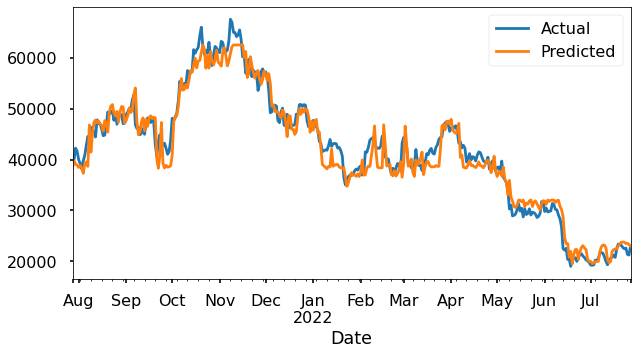

In [92]:
final_df.plot(figsize=(10,5))

In [103]:
error_rf = np.sqrt(mean_squared_error(final_df['Actual'],final_df['Predicted']))

In [104]:
error_rf

2607.8459576729547

In [105]:
percentage_rmse_data_mean_rf = (error_rf/mean)*100
percentage_rmse_data_mean_rf 

13.519849579294792

## Xgboost

In [94]:
xgb_r = xg.XGBRegressor()
 
# Fitting the model
xgb_r.fit(X_train, y_train)
 
# Predict the model
y_pred = xgb_r.predict(X_test)

print("R2 score:",xgb_r.score(X_test,y_test))
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE : % f" %(rmse))

R2 score: 0.9494470598659658
RMSE :  2607.845958


In [95]:
percentage_rmse_data_mean = (rmse/mean)*100
percentage_rmse_data_mean 

13.519849579294792

In [96]:
y_pred=pd.DataFrame(y_pred, index=y_new['Date'])

In [97]:
y_pred.columns=['Today']
y_pred

,Today
Date,
2021-07-28,38744.195312
2021-07-29,39491.242188
2021-07-30,38418.957031
2021-07-31,38854.375000
2021-08-01,38465.554688
...,...
2022-07-23,23691.365234
2022-07-24,23491.304688
2022-07-25,23491.304688


In [98]:
final_df=y_test.merge(y_pred, on='Date')
final_df.columns=['Actual', 'Predicted']
final_df

,Actual,Predicted
Date,,
2021-07-28,39995.90625,38744.195312
2021-07-29,40008.42188,39491.242188
2021-07-30,42235.54688,38418.957031
2021-07-31,41626.19531,38854.375000
2021-08-01,39974.89453,38465.554688
...,...,...
2022-07-23,22465.47852,23691.365234
2022-07-24,22609.16406,23491.304688
2022-07-25,21361.70117,23491.304688


<AxesSubplot:xlabel='Date'>

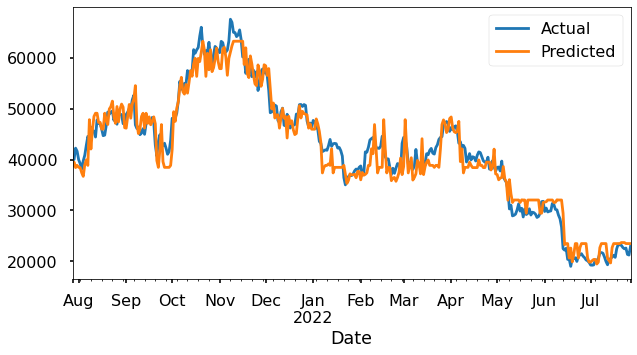

In [99]:
final_df.plot(figsize=(10,5))